In this notebook, we evaluate the possibility of using graph kernel attacks against TUDatasets. We focus on datasets with privacy applications.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tapas.datasets
import tapas.generators
import tapas.threat_models
import tapas.attacks

In [2]:
np.random.seed(13121)

## Real-world private datasets

The COLLAB dataset contains collaboration networks of academics. They are ego networks for these academics.

In [3]:
# If you have not yet downloaded the dataset:
# data = tapas.datasets.TUDataset.download_and_read("COLLAB")

# Otherwise:
# data = tapas.datasets.TUDataset.read("COLLAB", "COLLAB")

In [4]:
data = tapas.datasets.TUDataset.read("deezer_ego_nets", "deezer_ego_nets")

Loading TU graph dataset: deezer_ego_nets


## Memoized kernels

In our attacks, the main blocker is that kernels are computed many times over the same graph, leading to massive performance overheads. Memoization is the key here.

Importantly, we do not check whether graphs are identical, but merely whether they are stored in the same location in memory.

We also use this class to provide a clean interface between grakel kernels and networkx data.

In [5]:
import networkx as nx
from grakel.utils import graph_from_networkx

def _grak(graphs):
    # Add a label to the graphs, for compatibility with grakel.
    for G in graphs:
        # Relabel the graph nodes (useful for the kernel).
        nx.set_node_attributes(G, dict(zip(G.nodes, range(len(G.nodes)))), "label")
    return graph_from_networkx(graphs, node_labels_tag="label")

In [6]:
class Memoize:
    def __init__(self, kernel):
        self.kernel = kernel
        self.memory = {}
    
    def fit(self, tudataset):
        self.memory = {}  # Fitting the kernel resets the memory.
        self.kernel.fit(_grak(tudataset.data))

    def transform(self, tudataset):
        # Use G for the key, and grak(G) for the feature transformation.
        for G in tudataset.data:
            if G not in self.memory:
                self.memory[G] = self.kernel.transform(_grak([G]))[0]
        return np.stack([self.memory[G] for G in tudataset.data])

    def fit_transform(self, tudataset):        
        self.fit(tudataset)
        return self.transform(tudataset)

We now instantiate a typical kernel.

In [7]:
from grakel import WeisfeilerLehman, VertexHistogram

# TODO: find a better kernel -- vertex histogram is silly here, since there is very little (no?) overlap.
# We address this by relabelling nodes to 1..num_nodes.
kernel = Memoize(WeisfeilerLehman(n_iter=4, base_graph_kernel=VertexHistogram, normalize=True))

## Threat modelling (typical TAPAS)

We attack the Raw generator, for simplicity. This should be trivially attackable!

In [8]:
import pandas as pd

class BAGenerator(tapas.generators.Generator):
    def fit(self, dataset):
        self.description = dataset.description
        self.all_n = [len(G.nodes) for G in dataset.data]
        self.all_m = [max(1, int(np.round(len(G.edges)/len(G.nodes)))) for G in dataset.data]

    def generate(self, num_samples, random_state=None):
        indices = np.random.choice(len(self.all_n), size=(num_samples,))
        graphs = [nx.barabasi_albert_graph(self.all_n[i], self.all_m[i]) for i in indices]
        return tapas.datasets.TUDataset(pd.Series(graphs), self.description)

    @property
    def label(self):
        return "Barabasi-Albert Generator"

In [9]:
generator = BAGenerator()

We select arbitrary target(s) in the dataset.

In [10]:
target_indices = [0]

target_records = data.get_records(target_indices)
data.drop_records(target_indices, in_place=True)

In [46]:
g = target_records.data.iloc[0]

In [47]:
len(g.nodes)

287

We choose the auxiliary dataset setup (the attacker has access to a large number of real records disjoint from the real dataset).

In [11]:
size_private_dataset = 100
size_synthetic_dataset = 100
train_test_split = 0.5

In [12]:
import tqdm

In [12]:
threat_model = tapas.threat_models.TargetedMIA(
    attacker_knowledge_data = tapas.threat_models.AuxiliaryDataKnowledge(
        data, auxiliary_split=train_test_split, num_training_records=size_private_dataset,
    ),
    target_record = target_records,
    attacker_knowledge_generator=tapas.threat_models.BlackBoxKnowledge(
        generator, num_synthetic_records=size_synthetic_dataset,
    ),
    generate_pairs=False,
    replace_target=True,
)

## Attacks

We first define a few items that will be useful for attacking graphs.

In [13]:
class KernelFeature(tapas.attacks.SetFeature):
    """Extract some features from a graph, using a specific kernel."""
    
    def __init__(self, kernel):
        self.kernel = kernel
    
    def fit(self, tudataset):
        """Fit the kernel used by this feature using a dataset."""
        self.kernel.fit(tudataset)
    
    def extract(self, datasets):
        return np.stack([
            self.kernel.transform(d).mean(axis=0)
            for d in datasets
        ])

In [14]:
class KernelBasedDistance(tapas.attacks.DistanceMetric):
    """L2 distance between the kernels of two graphs."""
    
    # Using L2 is identical to RBF, since only the *order* matters.

    def __init__(self, kernel):
        self.kernel = kernel
        self._label = 'KernelBasedDistance'

    def fit(self, tudataset):
        """Fit the kernel used by this feature using a dataset."""
        self.kernel.fit(tudataset)

    def __call__(self, x, y):
        # Compute the distance matrix between two TUDatasets.
        ft_x = self.kernel.transform(x)
        ft_y = self.kernel.transform(y)
        dists = np.zeros((len(x), len(y)))
        for i, x1 in enumerate(ft_x):
            for j, x2 in enumerate(ft_y):
                dists[i,j] = np.linalg.norm(x1 - x2)
        return dists

#### Trained kernel

We use a fraction of the auxiliary dataset exclusively to fit the kernel. It is then discarded.

In [15]:
# A bit wordy, but we can extract the auxiliary data of the attacker as:
auxiliary_data = threat_model.atk_know_data.attacker_knowledge.aux_data

# We select a number of these graphs (200, for fun) which are dropped from the dataset.
# These records will be used exclusively to train the kernel.
kernel_training_data = auxiliary_data.create_subsets(n=1, sample_size = 200, drop_records=True)[0]

In [16]:
kernel.fit(kernel_training_data);

### Distance-based attack

In [17]:
dist = KernelBasedDistance(kernel)

In [18]:
attack = tapas.attacks.ClosestDistanceMIA(distance = dist, criterion = "accuracy")

In [19]:
# Training selects a threshold for the attack.
attack.train(threat_model, num_samples=100)

In [20]:
summary = threat_model.test(attack, num_samples=1000)

In [21]:
summary.get_metrics()

,dataset,target_id,generator,attack,accuracy,true_positive_rate,false_positive_rate,mia_advantage,privacy_gain,auc,effective_epsilon
0,deezer_ego_nets (AUX),0,Barabasi-Albert Generator,"ClosestDistance(KernelBasedDistance, accuracy)",0.795,0.625506,0.039526,0.58598,0.41402,0.814991,inf


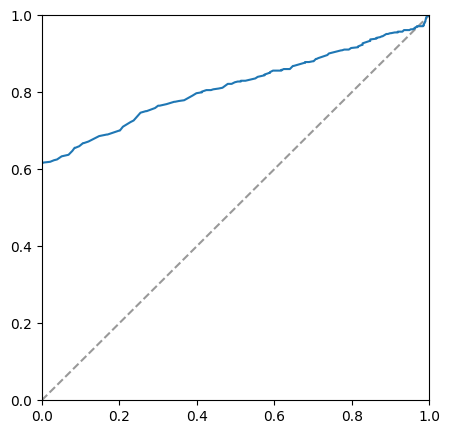

In [22]:
from sklearn.metrics import roc_curve
plt.figure(figsize=(5,5))
tpr, fpr, _ = roc_curve(summary.labels, summary.scores)
plt.plot([0,1], [0,1], 'k--', alpha=.4)
plt.plot(tpr, fpr)
plt.xlim([0,1])
plt.ylim([0,1]);

This attack achieves reasonable accuracy, surprisingly.

### Shadow-modelling attack

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [24]:
attack = tapas.attacks.ShadowModellingAttack(
    tapas.attacks.FeatureBasedSetClassifier(
        features = KernelFeature(kernel),
        classifier = RandomForestClassifier(),
    )
)

We first train with a small number of records. It works better than random, but not great.

In [25]:
# This involves feature extraction and training a model.
attack.train(threat_model, num_samples=100)

In [26]:
summary = threat_model.test(attack, num_samples=1000)

In [27]:
summary.get_metrics()

,dataset,target_id,generator,attack,accuracy,true_positive_rate,false_positive_rate,mia_advantage,privacy_gain,auc,effective_epsilon
0,deezer_ego_nets (AUX),0,Barabasi-Albert Generator,"ShadowModelling(Classifier(Unknown SetFeature,...",0.577,0.41498,0.264822,0.150158,0.849842,0.587469,1.921909


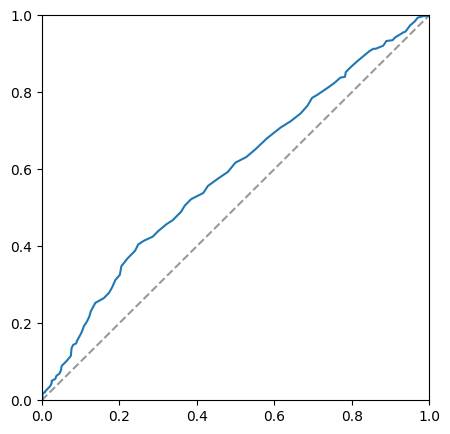

In [28]:
plt.figure(figsize=(5,5))
tpr, fpr, _ = roc_curve(summary.labels, summary.scores)
plt.plot([0,1], [0,1], 'k--', alpha=.4)
plt.plot(tpr, fpr)
plt.xlim([0,1])
plt.ylim([0,1]);

We now train with a larger number of samples. Now the shadow-modelling attack works very well!

In [29]:
attack.train(threat_model, num_samples=1000)

In [30]:
summary = threat_model.test(attack, num_samples=1000)

In [31]:
summary.get_metrics()

,dataset,target_id,generator,attack,accuracy,true_positive_rate,false_positive_rate,mia_advantage,privacy_gain,auc,effective_epsilon
0,deezer_ego_nets (AUX),0,Barabasi-Albert Generator,"ShadowModelling(Classifier(Unknown SetFeature,...",0.638,0.55668,0.282609,0.274071,0.725929,0.683356,2.914373


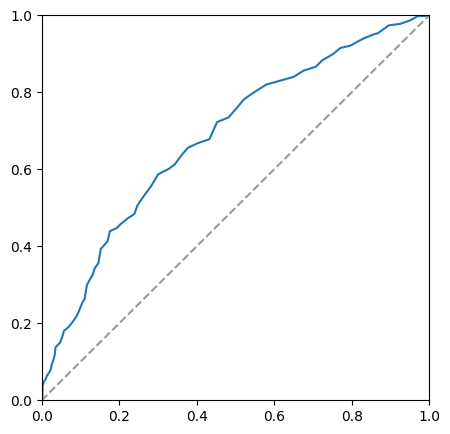

In [32]:
plt.figure(figsize=(5,5))
tpr, fpr, _ = roc_curve(summary.labels, summary.scores)
plt.plot([0,1], [0,1], 'k--', alpha=.4)
plt.plot(tpr, fpr)
plt.xlim([0,1])
plt.ylim([0,1]);

### Composed graph classifier

We now use our custom composed graph classifier (using the same parameters otherwise). Note that this is very slow, since the kernel needs to be recomputed for every dataset.

Surprisingly, this works much better (although it is noticeably slower). Also the results seem to be sensitive to the randomness in the kernel sample.

In [33]:
attack = tapas.attacks.ShadowModellingAttack(
    tapas.attacks.ComposedGraphClassifier(
        classifier = RandomForestClassifier(),
        # Remove all memoization (this expects a grakel.Kernel).
        kernel = kernel.kernel
    ),
    label = 'ComposedAttack'
)

In [34]:
attack.train(threat_model, num_samples=100)

In [35]:
summary = threat_model.test(attack, num_samples=1000)

In [36]:
summary.get_metrics()

,dataset,target_id,generator,attack,accuracy,true_positive_rate,false_positive_rate,mia_advantage,privacy_gain,auc,effective_epsilon
0,deezer_ego_nets (AUX),0,Barabasi-Albert Generator,ComposedAttack,0.731,0.718623,0.256917,0.461706,0.538294,0.816014,inf


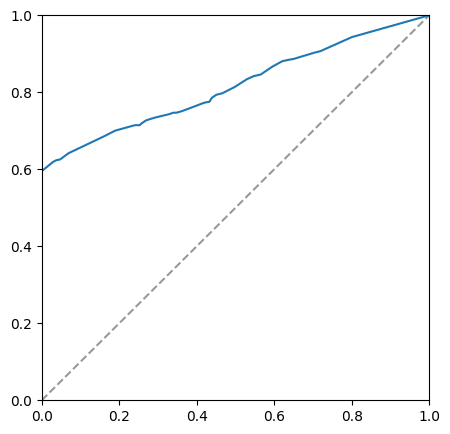

In [37]:
plt.figure(figsize=(5,5))
tpr, fpr, _ = roc_curve(summary.labels, summary.scores)
plt.plot([0,1], [0,1], 'k--', alpha=.4)
plt.plot(tpr, fpr)
plt.xlim([0,1])
plt.ylim([0,1]);

this works surprisingly well (I tested the training accuracy/AUC, it's basically 1)! We now try with more samples.

In [38]:
attack.train(threat_model, num_samples=1000)

In [39]:
summary = threat_model.test(attack, num_samples=1000)

In [40]:
summary.get_metrics()

,dataset,target_id,generator,attack,accuracy,true_positive_rate,false_positive_rate,mia_advantage,privacy_gain,auc,effective_epsilon
0,deezer_ego_nets (AUX),0,Barabasi-Albert Generator,ComposedAttack,0.775,0.6417,0.094862,0.546839,0.453161,0.798853,inf


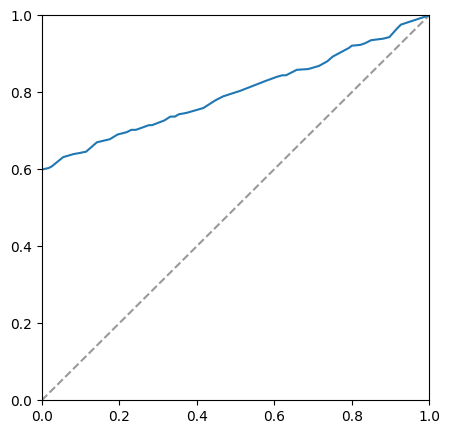

In [42]:
plt.figure(figsize=(5,5))
tpr, fpr, _ = roc_curve(summary.labels, summary.scores)
plt.plot([0,1], [0,1], 'k--', alpha=.4)
plt.plot(tpr, fpr)
plt.xlim([0,1])
plt.ylim([0,1]);

Any improvement with more samples is very marginal.